# Day_07 - Julia's `Symbolics`: Computer Algebra System
## Let the computer do the hard work

The double-pendulum from [Day_06](./day_06.md) was a great success. I got some experience building differential equations, pseudo-benchmarking some results, and building some excellent animations. One of the tough parts of physical simulations is getting all the math worked out correctly. Its satisfying to eliminate terms and come up with a final equation of motion, kind of like a Sudoku puzzle or Wordle game, but it takes time. When you start the next problem, you're back to square one. 

## Enter [Computer Algebra Systems](https://en.wikipedia.org/wiki/Computer_algebra_system)

Computer Algebra Systems (CAS) allow you to create objects that follow symbolic algebra, calculus, etc. I avoided CAS programs for years because it felt so difficult to get the equations back into a numerical form. As an engineer, I mostly deal with tables, fractions, percents, etc. I don't always need or want an exact function. That's why CFD, FEA, and multibody dynamics are so useful to engineers. 

## Julia's CAS `using Symbolics`

There are some great examples on [Symbolics.jl documentation](https://symbolics.juliasymbolics.org/stable/tutorials/symbolic_functions). Here, I want to
1. build some simple sets of functions
2. take some derivatives
3. create a callable numerical function (not a CAS object)

In [1]:
using Plots, DifferentialEquations, LaTeXStrings, Symbolics

## Build a set of functions and the Jacobian

The first thing I build is a set of functions and its Jacobian, 

$\mathbf{f}(x_1,x_2) = 
\left[
\begin{array}{c}
x_2 + x_1^{2} \\
x_1 + x_2^{2} \\
\end{array}
\right]
$

$\frac{\partial f_i}{\partial x_j} = 
\left[
\begin{array}{cc}
2 x_{1} & 1 \\
1 & 2 x_{2} \\
\end{array}
\right]$

There were a few tricks to get everything in the right place and cooperating. So here is the process
1. define the variables `x_1` and `x_2`
2. define $\mathbf{f(x)}$ `f`
3. build the function `f_x` with [`build_function`](https://symbolics.juliasymbolics.org/stable/tutorials/symbolic_functions/#Building-Functions-1)
4. evaluate the _first_ returned output from `build_function`

### 1. define the variables `x_1` and `x_2`

In [2]:
@variables x_1, x_2

2-element Vector{Num}:
 x_1
 x_2

### 2. define $\mathbf{f(x)}$ `f`

Here, I use the same array definitions as Julia to build a vector of functions. 

In [3]:
f = [x_1^2 + x_2, x_2^2 + x_1]

2-element Vector{Num}:
 x_2 + x_1^2
 x_1 + x_2^2

### 3. build the function `f_x` with [`build_function`](https://symbolics.juliasymbolics.org/stable/tutorials/symbolic_functions/#Building-Functions-1)

To get a reusable, numerical function, I want to define a Julia function. I could hard code it in, but then I'm back to doing all the math myself. The `build_function` is a fast Julia interpretation of the algebra contained in the CAS function. It returns a full `function` that can be saved as a `*.jl` file. 

> __Note__: There is a new term to me called the [world-age issues](https://arxiv.org/abs/2010.07516) that has to do with _where_ and _when_ the function is defined. This method using `eval` creates a new _world_ within the Julia session that cannot be precompiled. I believe saving this to the `*.jl` file is a workaround to this slow-down. 

In [4]:
f_x= build_function(f, x_1, x_2, expression = Val{false})

(RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:x_1, :x_2), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0x6a792526, 0xcbf59f6b, 0x6d67a95f, 0x96e674fe, 0x64d4827f)}(quote
    #= /home/ryan/.julia/packages/SymbolicUtils/v2ZkM/src/code.jl:349 =#
    #= /home/ryan/.julia/packages/SymbolicUtils/v2ZkM/src/code.jl:350 =#
    #= /home/ryan/.julia/packages/SymbolicUtils/v2ZkM/src/code.jl:351 =#
    begin
        #= /home/ryan/.julia/packages/SymbolicUtils/v2ZkM/src/code.jl:444 =#
        (SymbolicUtils.Code.create_array)(Array, nothing, Val{1}(), Val{(2,)}(), (+)(x_2, (^)(x_1, 2)), (+)(x_1, (^)(x_2, 2)))
    end
end), RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:ˍ₋out, :x_1, :x_2), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0x184abcc3, 0x978c6f1e, 0x2ab512ab, 0xe6b23c0f, 0xaf4ffa04)}(quote
    #= /home/ryan/.julia/packages/SymbolicUtils/v2ZkM/src/code.jl:349 =#
    #= /home/ryan/.julia/packages/SymbolicUtils/v2ZkM/src/code.jl:350 =#
    #= /home/rya

### 4. evaluate the _first_ returned output from `build_function`

In this case, there are two functions: 
1. The first is a function f([x, y]) that computes and builds an output vector $[x_1^2 + x_2,~x_2^2 + x_1]$. 
2. The second function is an in-place non-allocating mutating function which mutates its first value

I don't need the second function at the moment, so I evaluate the first function. 

In [5]:
out = f_x[1](1.0, 2.0)

2-element Vector{Float64}:
 3.0
 5.0

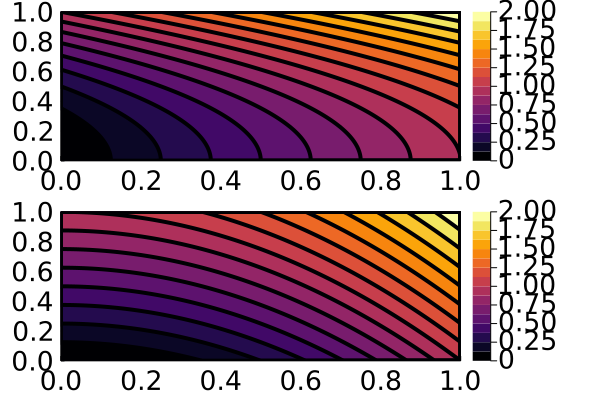

In [6]:
Plots.theme(:cooper)
x1_array = range(0, 1, length = 100)
x2_array = range(0, 1, length = 100)
Farray1 = [f_x[1](x1i, x2i)[1] for x1i in x1_array for x2i in x2_array]
Farray2 = [f_x[1](x1i, x2i)[2] for x1i in x1_array for x2i in x2_array]

l = @layout [a; b]
p = contourf(x1_array, x2_array, Farray1, layout = l)
contourf!(p[2], x1_array, x2_array, Farray2)



### Evaluate the Jacobian

Success! Now, I can calculate the Jacobian $\frac{\partial f_i}{\partial x_i}$ and evaluate its result with the same steps. 

First, create the symbolic function, `DJ`, with `.jacobian`.

In [7]:
DJ = Symbolics.jacobian(f, [x_1, x_2])

2×2 Matrix{Num}:
 2x_1     1
    1  2x_2

Next, `build_function` and `eval` the result. 

In [8]:
DJ_xy = build_function(DJ, [x_1, x_2], expression = Val{false})
DJ_xy[1]([3, 2])

2×2 Matrix{Int64}:
 6  1
 1  4

Success! 

## Make a time-varying array of functions

Now, I want to create a set of functions that vary with time, take the derivative and evaluate the results. 

> This will give me the piece I need for the $\frac{d}{dt}\left(\frac{\partial L}{\partial \dot{q}_i}\right)$ calculations. 

I want to build, 

$\mathbf{g(z)} = \left[
\begin{array}{c}
\mathrm{z{_1}}\left( t \right) \mathrm{z{_2}}\left( t \right) \\
2 \mathrm{z{_4}}\left( t \right) + \mathrm{z{_2}}\left( t \right) + \mathrm{z{_3}}\left( t \right) \\
 - \left( \mathrm{z{_4}}\left( t \right) \right)^{2} + \left( \mathrm{z{_1}}\left( t \right) \right)^{2} \\
\end{array}
\right]$

then, take the derivative, 

$\frac{d}{dt}(\mathbf{g(z)})=\left[
\begin{array}{c}
\mathrm{z{_1}}\left( t \right) \frac{dz{_2}(t)}{dt} + \mathrm{z{_2}}\left( t \right) \frac{dz{_1}(t)}{dt} \\
2 \frac{dz{_4}(t)}{dt} + \frac{dz{_2}(t)}{dt} + \frac{dz{_3}(t)}{dt} \\
2 \mathrm{z{_1}}\left( t \right) \frac{dz{_1}(t)}{dt} - 2 \mathrm{z{_4}}\left( t \right) \frac{dz{_4}(t)}{dt} \\
\end{array}
\right]$

### Build a $d/dt$ operator

The next function, I make is just an operator. It takes derivatives of variables that are a function of `t`, time. Now, I can create differential equations. 

First, define `t`

In [9]:
@variables t

1-element Vector{Num}:
 t

Now, define the $\frac{d}{dt}$ as `Differential(t)`

In [10]:
D = Differential(t)

(::Differential) (generic function with 2 methods)

Now, I create four variables, $\mathbf{z} = [z_1,~z_2,~z_3,z_4]$ that are functions of time. I use the shortcut to create an array of symbols `z[1:4]` and the `(t)` to indicate that each variable is a function of time. 

In [11]:
@variables z[1:4](t)
z = [zi for zi in z]

4-element OffsetArray(::Vector{Num}, 1:4) with eltype Num with indices 1:4:
 z[1](t)
 z[2](t)
 z[3](t)
 z[4](t)

Then, I can define the derivatives of each of these variables. 

In [12]:
dz = D.(z)

4-element OffsetArray(::Vector{Num}, 1:4) with eltype Num with indices 1:4:
 Differential(t)(z[1](t))
 Differential(t)(z[2](t))
 Differential(t)(z[3](t))
 Differential(t)(z[4](t))

Next, build the function $\mathbf{g(z)}$

In [13]:
g = [z[1]*z[2], z[3]+z[2]+2*z[4], z[1]^2-z[4]^2]

3-element Vector{Num}:
              z[1](t)*z[2](t)
 2z[4](t) + z[2](t) + z[3](t)
      z[1](t)^2 - (z[4](t)^2)

When I take the derivative of `g` with `D.`, it is a lazy evaluation. To get the expanded result, I call out `expand_derivatives` from Symbolics.jl. 

In [14]:
D.(g)

3-element Vector{Num}:
 Differential(t)(z[1](t)*z[2](t))
 Differential(t)(2z[4](t) + z[2](t) + z[3](t))
 Differential(t)(z[1](t)^2 - (z[4](t)^2))

> __Note__: "Lazy" evaluation is not a negative comment on the function. I'm just pointing out that it doesn't fully evaluate the result until I think it's necessary. Its a _feature_ not a _bug_. 

In [15]:
Dg = expand_derivatives.(D.(g))

3-element Vector{Num}:
  z[1](t)*Differential(t)(z[2](t)) + z[2](t)*Differential(t)(z[1](t))
         2Differential(t)(z[4](t)) + Differential(t)(z[2](t)) + Differential(t)(z[3](t))
 2z[1](t)*Differential(t)(z[1](t)) - 2z[4](t)*Differential(t)(z[4](t))

### Tripping point for z(t) as a callable variable

This was a wall that I hit, hopefully you can learn from my mistakes. When I try to `build_function` and `eval` the resulting code, I get this error that `(z[1](t)) is not callable`. I believe it has to do with the assumption that `z` is a function of time on my part. 

```julia
julia> build_function(Dg, z, dz)
julia> eval(Dg[1])([1,3,5,7], [2,4,6,8])

Sym z[1](t)*Differential(t)(z[2](t)) + z[2](t)*Differential(t)(z[1](t)) is not callable. Use @syms z[1](t)*Differential(t)(z[2](t)) + z[2](t)*Differential(t)(z[1](t))(var1, var2,...) to create it as a callable.

Stacktrace:
 [1] error(s::String)
   @ Base ./error.jl:33
 [2] (::SymbolicUtils.Add{Real, Int64, Dict{Any, Number}, Nothing})(::Vector{Int64}, ::Vararg{Vector{Int64}})
   @ SymbolicUtils ~/.julia/packages/SymbolicUtils/v2ZkM/src/types.jl:172
 [3] (::Num)(::Vector{Int64}, ::Vararg{Vector{Int64}})
   @ Symbolics ~/.julia/packages/Symbolics/HDE84/src/num.jl:17
 [4] top-level scope
   @ In[267]:2
 [5] eval
   @ ./boot.jl:373 [inlined]
 [6] include_string(mapexpr::typeof(REPL.softscope), mod::Module, code::String, filename::String)
   @ Base ./loading.jl:1196
```

### Work-around for non-callable function variables

Here is my workaround:
1. create callable variables `q` and `dq` with the same length as `z(t)`
2. substitute the values into the `Dg` symbolic function and simplify the results
3. build the function with the `q` and `dq` callable variables

I substitute the `dq` variables first, so I don't end up with $\frac{d}{dt}(q_i)$-terms. The `susbstitute` function acts as such

- `substitute.` makes substitutions on each function within the vector `Dg`
- `Dict(dz[i] => dq[i])` and `Dict(z[i] => q[i])` replaces each $z_i(t)$ with $q_i$ 
- `for i in range(1,4)` loops the dictionary from `z[1] to z[4]`

In [16]:
@variables q[1:4]
@variables dq[1:4]
Dgdq = simplify.(substitute.(Dg, (Dict(dz[i] => dq[i] for i in range(1, 4)),)))
gq = simplify.(substitute.(g, (Dict(z[i] => q[i] for i in range(1, 4)),)))
Dgq = simplify.(substitute.(Dgdq, (Dict(z[i] => q[i] for i in range(1, 4)),)))



3-element Vector{Num}:
   dq[2]*q[1] + dq[1]*q[2]
    2dq[4] + dq[2] + dq[3]
 2dq[1]*q[1] - 2dq[4]*q[4]

Finally, I can `build_function` from `Dgq` and `eval` the result. 

In [17]:
g_func = build_function(gq, q, expression = Val{false})
Dg_func = build_function(Dgq, q, dq, expression = Val{false})
Dg_func[1]([1,3,5,7], [2,4,6,8])
# eval(Dg_func[1])([1,3,5,7], [2,4,6,8])

3-element Vector{Int64}:
   10
   26
 -108

## Animate some function evaluations

Finally, I want to build an animation of the functions I am building, $\mathbf{g(z)}~and~\frac{d\mathbf{g}}{dt}$. I have to define my numerical variable space

- time, `t_space` from 0 - $2\pi$ seconds
- $\mathbf{z}$, `z_space` as $\sin(t+\phi)$
- $\mathbf{\dot{z}}$, `dz_space` as $\cos(t+\phi)$
- $\mathbf{g(z)}$, `g_val` as the evaluated `g_func`
- $\mathbf{\dot{g}(z,\dot{z})}$, `Dg_val` as the evaluated `Dg_func`

In [18]:
t_space = range(0,2*pi, length = 200)

0.0:0.03157379551346526:6.283185307179586

Here, I plot the values for $z~and~\dot{z}$. 

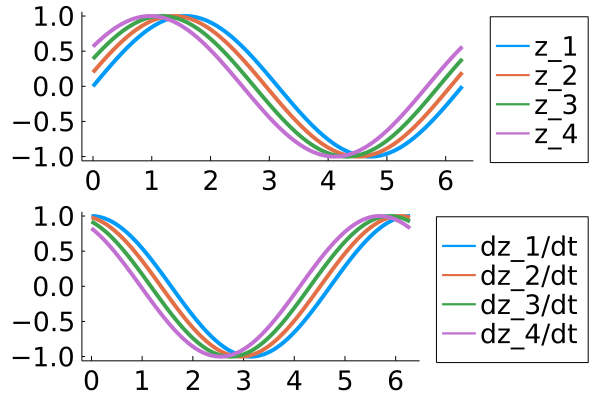

In [19]:
l = @layout [a; b]
z_space = zeros(length(t_space), 4)
dz_space = zeros(length(t_space), 4)
p = plot(title = "", layout = l)
for (i, phi) in enumerate([0, 0.2, 0.4, 0.6])
    z_space[:, i] = sin.(t_space .+ phi)
    dz_space[:, i] = cos.(t_space .+ phi)
    plot!(p[1], t_space, sin.(t_space .+ phi), label = "z_$i")
    plot!(p[2], t_space, cos.(t_space .+ phi), label = "dz_$i/dt")
    plot
end
p

Now, I plot the evaluated $\mathbf{g(z)}~and~\mathbf{\dot{g}(z)}$

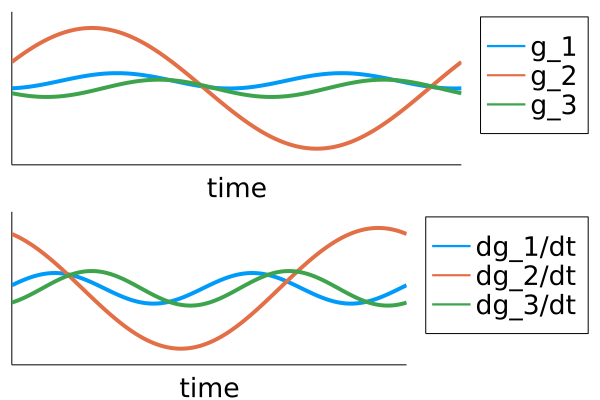

In [20]:
l = @layout [a; b]
p = plot(xlabel = "time", layout = l, xlim = (0, 2*pi), ylim = (-5, 5))
g_val = zeros(length(t_space), 3)
Dg_val = zeros(length(t_space), 3)
for i in range(1, length(t_space))
    g_val[i, :] = g_func[1](z_space[i, :])
    Dg_val[i, :] = Dg_func[1](z_space[i, :], dz_space[i, :])
end
for i in range(1, 3)
    plot!(p[1], t_space, g_val[:, i], axis = nothing, label = "g_$i")
    plot!(p[2], t_space, Dg_val[:, i], axis = nothing, label = "dg_$i/dt")
end
p

Finally, I can combine the input+evaluations into one animated gif to see the effects of $\mathbf{z}(t)$ on $\mathbf{\dot{z},~g,~\dot{g}}$. 

┌ Info: Saved animation to 
│   fn = /home/ryan/Documents/Career_docs/cooperrc-gh-pages/Julia-learning/tmp.gif
└ @ Plots /home/ryan/.julia/packages/Plots/D9pfj/src/animation.jl:114


Plots.AnimatedGif("/home/ryan/Documents/Career_docs/cooperrc-gh-pages/Julia-learning/tmp.gif")
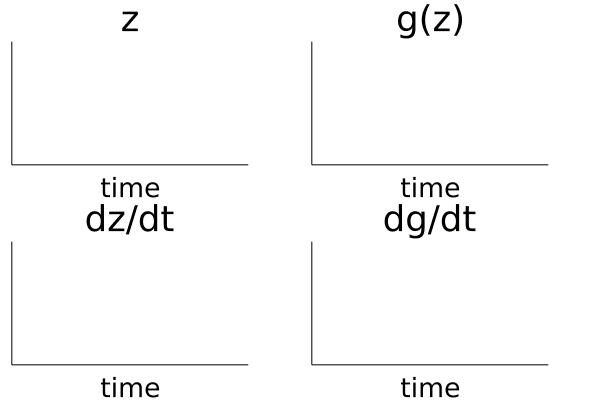

In [21]:
l = @layout [a b; c d]
p = plot(xlabel = "time", layout = l, xlim = (0, 2*pi))#, ylim = (-5, 5))
import ColorSchemes.rainbow

@gif for ti in range(1, length(t_space))
    
    for i in range(1, 4)
        color = get(rainbow, (i-1)/(3))
        plot!(p[1], t_space[1:ti], z_space[1:ti, i], axis = nothing, label = "", title="z", linecolor = color)
        plot!(p[3], t_space[1:ti], dz_space[1:ti, i], axis = nothing, label = "", title = "dz/dt", linecolor = color)
    end
    for i in range(1, 3)
        color = get(rainbow, (i-1)/(2))
        plot!(p[2], t_space[1:ti], g_val[1:ti, i], axis = nothing, label = "", title = "g(z)",linecolor = color)
        plot!(p[4], t_space[1:ti], Dg_val[1:ti, i], axis = nothing, label = "", title = "dg/dt", linecolor = color)
    end
end

In [22]:
print("Plotted above are the evaluations for g1(z1,z2,z3,z4), g2(z1,z2,z3,z4), g3(z1,z2,z3,z4)\n")
g

Plotted above are the evaluations for g1(z1,z2,z3,z4), g2(z1,z2,z3,z4), g3(z1,z2,z3,z4)


3-element Vector{Num}:
              z[1](t)*z[2](t)
 2z[4](t) + z[2](t) + z[3](t)
      z[1](t)^2 - (z[4](t)^2)

__Success!__

## Wrapping up

Today I spent a chunk of time building and debugging symbolic algebra code. To me, the hardest part is always getting the CAS objects back into a function that can be evaluated, integrated, optimized, etc. The $\LaTeX$ output of the Symbolics.jl package are excellent. The ability to create differential operators and set up equations is amazing. I was able to define arrays of functions with multiple variables, take partial derivatives with the `.jacobian`, and full derivatives with `Differential(...)`. 

I am still wrapping my head around the output from [`build_function`](https://symbolics.juliasymbolics.org/stable/tutorials/symbolic_functions/#Building-Functions-1). It seems like the best practice is to create a seperate `*.jl` file, but for now I got the numerical functions to evaluate based upon their symbolic counterparts. The [world-age]() problem is new to me. Coming from Python+MATLAB, I hadn't really worried about or considered where and when my functions were compiled. I would guess that getting these concepts in Julia would also help in Python/MATLAB. 

Coming up next: I'll build a set of differential equations based upon the Lagrange equations $\frac{d}{dt}\left(\frac{\partial L}{\partial \dot{q}_i}\right) - \frac{\partial L}{\partial q_i}= 0$. 